In [1]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import time
import os
from dataclasses import dataclass
from collections import namedtuple
import pyro
import optax
from pyro.infer import SVI, TraceGraph_ELBO
import pyro.distributions as dist
import pyro.poutine as poutine
import pyro.contrib.examples.multi_mnist as multi_mnist
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import matplotlib.font_manager as font_manager
from matplotlib.patches import Rectangle
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import seaborn as sns
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib import rcParams
from scipy.interpolate import griddata
import genjax
from genjax import grasp
from genjax import Pytree
import equinox as eqx
from genjax.typing import Any
from genjax.typing import Tuple
from genjax.typing import FloatArray
from genjax.typing import Int
from genjax.typing import IntArray
from genjax.typing import PRNGKey
from genjax.typing import typecheck
from genjax import choice_map

from numpyro.examples.datasets import MNIST
from numpyro.examples.datasets import load_dataset

import genjax
from genjax import grasp
from genjax import gensp
from genjax import select

import adevjax

console = genjax.pretty()
key = jax.random.PRNGKey(314159)
sns.set_theme(style="white")
font_path = (
    "/home/femtomc/.local/share/fonts/Unknown Vendor/TrueType/Lato/Lato_Bold.ttf"
)
font_manager.fontManager.addfont(font_path)
custom_font_name = font_manager.FontProperties(fname=font_path).get_name()
rcParams["font.family"] = custom_font_name
rcParams["figure.autolayout"] = True
label_fontsize = 70  # Set the desired font size here

train_init, train_fetch = load_dataset(MNIST, batch_size=4096, split="train")
num_train, train_idx = train_init()
data_batch = train_fetch(0)[0]
batch_sizes = [64, 128, 256, 512, 1024, 2048, 4092, 9184]

In [2]:
# Utilities for defining the model and the guide.
@dataclass
class Decoder(Pytree):
    dense_1: Any
    dense_2: Any

    def flatten(self):
        return (self.dense_1, self.dense_2), ()

    @classmethod
    def new(cls, key1, key2):
        dense_1 = eqx.nn.Linear(10, 200, key=key1)
        dense_2 = eqx.nn.Linear(200, 28 * 28, key=key2)
        return Decoder(dense_1, dense_2)

    def __call__(self, z_what):
        v = self.dense_1(z_what)
        v = jax.nn.leaky_relu(v)
        v = self.dense_2(v)
        return jax.nn.sigmoid(v)


# Create our decoder.
key, sub_key1, sub_key2 = jax.random.split(key, 3)
decoder = Decoder.new(sub_key1, sub_key2)


@dataclass
class Encoder(Pytree):
    dense_1: Any
    dense_2: Any

    def flatten(self):
        return (self.dense_1, self.dense_2), ()

    @classmethod
    def new(cls, key1, key2):
        dense_1 = eqx.nn.Linear(28 * 28, 200, key=key1)
        dense_2 = eqx.nn.Linear(200, 20, key=key2)
        return Encoder(dense_1, dense_2)

    def __call__(self, data):
        v = self.dense_1(data)
        v = jax.nn.leaky_relu(v)
        v = self.dense_2(v)
        return v[0:10], jax.nn.softplus(v[10:])


key, sub_key1, sub_key2 = jax.random.split(key, 3)
encoder = Encoder.new(sub_key1, sub_key2)

In [3]:
@genjax.gen
def model(decoder):
    latent = genjax.tfp_mv_normal_diag(jnp.zeros(10), jnp.ones(10)) @ "latent"
    logits = decoder(latent)
    _ = genjax.tfp_bernoulli(logits) @ "image"


@genjax.gen
def guide(encoder, chm):
    image = chm["image"]
    μ, Σ_scale = encoder(image)
    _ = grasp.mv_normal_diag_reparam(μ, Σ_scale) @ "latent"


def batch_elbo_grad_estimate(key, encoder, decoder, data_batch):
    def _inner(key, encoder, decoder, data):
        chm = choice_map({"image": data.flatten()})
        objective = grasp.elbo(model, guide, chm)
        return objective.grad_estimate(key, ((decoder,), (encoder, chm)))

    sub_keys = jax.random.split(key, len(data_batch))
    return jax.vmap(_inner, in_axes=(0, None, None, 0))(
        sub_keys, encoder, decoder, data_batch
    )


jit1 = jax.jit(batch_elbo_grad_estimate)

# Warmup
jit1(key, encoder, decoder, data_batch);

In [4]:
grasp_runtime_over_batches = []
for batch_size in batch_sizes:
    print(batch_size)
    train_init, train_fetch = load_dataset(MNIST, batch_size=batch_size, split="train")
    num_train, train_idx = train_init()
    data_batch = train_fetch(0)[0]
    durations = []
    for i in range(0, 5000):
        t0 = time.perf_counter()
        jit1(key, encoder, decoder, data_batch)
        duration = time.perf_counter() - t0
        durations.append(duration)
    grasp_runtime_over_batches.append(jnp.mean(jnp.array(durations)))
print(grasp_runtime_over_batches)

64
128
256
512
1024
2048
4092
9184
[Array(0.00023641, dtype=float32), Array(0.00032592, dtype=float32), Array(0.00052497, dtype=float32), Array(0.00099217, dtype=float32), Array(0.00193557, dtype=float32), Array(0.00361052, dtype=float32), Array(0.00680586, dtype=float32), Array(0.01488859, dtype=float32)]


In [13]:
@jax.jit
def epoch_train(params, opt_state, key, train_idx):
    def body_fn(carry, xs):
        idx, opt_state, params = carry
        updater_key = jax.random.fold_in(key, idx)
        batch = train_fetch(idx, train_idx)[0]
        ((decoder_grads,), (encoder_grads, _)) = batch_elbo_grad_estimate(
            updater_key, encoder, decoder, batch
        )
        grads = (encoder_grads, decoder_grads)
        grads = jtu.tree_map(lambda v: jnp.mean(v, axis=0), grads)
        updates, opt_state = optax.adam(1e-3).update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        idx += 1
        return (idx, opt_state, params), ()

    idx = 0
    (_, _, params), () = jax.lax.scan(
        body_fn, (idx, opt_state, params), None, length=64
    )
    return params, 0.0


params = (encoder, decoder)
grasp_epoch_times = []
for i in range(0, 500):
    if i % 50 == 0:
        print(i)
    train_init, train_fetch = load_dataset(MNIST, batch_size=64, split="train")
    adam = optax.adam(1e-3)
    opt_state = adam.init(params)
    num_batch, train_idx = train_init()
    key, sub_key = jax.random.split(key)
    t0 = time.perf_counter()
    params, loss = epoch_train(params, opt_state, sub_key, train_idx)
    duration = time.perf_counter() - t0
    if i != 0:
        grasp_epoch_times.append(duration)

grasp_epoch_times

0
50
100
150
200
250
300
350
400
450



[
    0.002992823996464722,
    0.004391134003526531,
    0.0029952679979032837,
    0.0034461160030332394,
    0.004419135999341961,
    0.0029744780040346086,
    0.003269800996349659,
    0.0029898479988332838,
    0.002981302000989672,
    0.005811976996483281,
    0.0034090150002157316,
    0.004410399000335019,
    0.00297587200475391,
    0.0029664829999092035,
    0.002963949002150912,
    0.002972906004288234,
    0.0029720840029767714,
    0.0030634579961770214,
    0.0029643599991686642,
    0.0029727360015385784,
    0.00295533100143075,
    0.002961934995255433,
    0.0029787870007567108,
    0.003172063996316865,
    0.003162216002237983,
    0.003177744998538401,
    0.0031627270000171848,
    0.003217851000954397,
    0.003330024999740999,
    0.0033946579933399335,
    0.003168787996401079,
    0.003177444996254053,
    0.0031559540002490394,
    0.0031723139982204884,
    0.003166873997543007,
    0.0031726050001452677,
    0.0031795179966138676,
    0.00317312699917

In [14]:
from tensorflow_probability.substrates import jax as tfp

tfd = tfp.distributions

MvNormalDiag = tfd.MultivariateNormalDiag
Bernoulli = tfd.Bernoulli

# Manual.
def batch_elbo_grad_estimate(key, encoder, decoder, data_batch):
    def single_estimate(key, encoder, decoder, data):
        image = data.flatten()

        def loss_estimate(params):
            (encoder, decoder) = params
            μ, Σ_scale = encoder(image)
            v = MvNormalDiag(jnp.zeros(10), jnp.ones(10)).sample(seed=key)
            s = μ + v * Σ_scale
            guide_normal_logp = MvNormalDiag(μ, Σ_scale).log_prob(s)
            model_normal_logp = MvNormalDiag(jnp.zeros(10), jnp.ones(10)).log_prob(s)
            logits = decoder(s)
            model_bernoulli_logp = Bernoulli(logits=logits).log_prob(image).sum()
            return (model_bernoulli_logp + model_normal_logp) - guide_normal_logp

        return jax.grad(loss_estimate)((encoder, decoder))

    sub_keys = jax.random.split(key, len(data_batch))
    return jax.vmap(single_estimate, in_axes=(0, None, None, 0))(
        sub_keys, encoder, decoder, data_batch
    )


jit2 = jax.jit(batch_elbo_grad_estimate)

# Warm up.
jit2(key, encoder, decoder, data_batch);

In [15]:
@jax.jit
def epoch_train(params, opt_state, key, train_idx):
    def body_fn(carry, xs):
        idx, opt_state, params = carry
        updater_key = jax.random.fold_in(key, idx)
        batch = train_fetch(idx, train_idx)[0]
        grads = batch_elbo_grad_estimate(updater_key, encoder, decoder, batch)
        grads = jtu.tree_map(lambda v: jnp.mean(v, axis=0), grads)
        updates, opt_state = optax.adam(1e-3).update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        idx += 1
        return (idx, opt_state, params), ()

    idx = 0
    (_, _, params), () = jax.lax.scan(
        body_fn, (idx, opt_state, params), None, length=64
    )
    return params, 0.0


params = (encoder, decoder)
hand_epoch_times = []
for i in range(0, 500):
    if i % 50 == 0:
        print(i)
    train_init, train_fetch = load_dataset(MNIST, batch_size=64, split="train")
    adam = optax.adam(1e-3)
    opt_state = adam.init(params)
    num_batch, train_idx = train_init()
    key, sub_key = jax.random.split(key)
    t0 = time.perf_counter()
    params, loss = epoch_train(params, opt_state, sub_key, train_idx)
    duration = time.perf_counter() - t0
    if i != 0:
        hand_epoch_times.append(duration)

hand_epoch_times

0
50
100
150
200
250
300
350
400
450



[
    0.0016256119997706264,
    0.0016034410000429489,
    0.0015953350011841394,
    0.0015926100022625178,
    0.001624600998184178,
    0.0016120469954330474,
    0.0016162450046977028,
    0.0015786330041009933,
    0.0016111349978018552,
    0.001597299000422936,
    0.0016033600040827878,
    0.0015949440057738684,
    0.0016091920042526908,
    0.0016058949986472726,
    0.0016011760017136112,
    0.00159523500042269,
    0.001599081006133929,
    0.001609992999874521,
    0.0016214450006373227,
    0.0016068170007201843,
    0.0015952440007822588,
    0.001597107999259606,
    0.001607548001629766,
    0.001604090997716412,
    0.001579796000442002,
    0.001598060000105761,
    0.001626292993023526,
    0.0016009050013963133,
    0.001607899001101032,
    0.001602869997441303,
    0.001608771002793219,
    0.0016318540001520887,
    0.001595063993590884,
    0.0016010050021577626,
    0.0016082500005722977,
    0.0015972690016496927,
    0.0015991220061550848,
    0.00160077

In [16]:
hand_runtime_over_batches = []
for batch_size in batch_sizes:
    print(batch_size)
    train_init, train_fetch = load_dataset(MNIST, batch_size=batch_size, split="train")
    num_train, train_idx = train_init()
    data_batch = train_fetch(0)[0]
    durations = []
    for i in range(0, 5000):
        t0 = time.perf_counter()
        jit2(key, encoder, decoder, data_batch)
        duration = time.perf_counter() - t0
        durations.append(duration)
    hand_runtime_over_batches.append(jnp.mean(jnp.array(durations)))
print(hand_runtime_over_batches)

64
128
256
512
1024
2048
4092
9184
[Array(0.0001759, dtype=float32), Array(0.00027918, dtype=float32), Array(0.00047446, dtype=float32), Array(0.00085434, dtype=float32), Array(0.00160643, dtype=float32), Array(0.00311204, dtype=float32), Array(0.00615088, dtype=float32), Array(0.01374883, dtype=float32)]


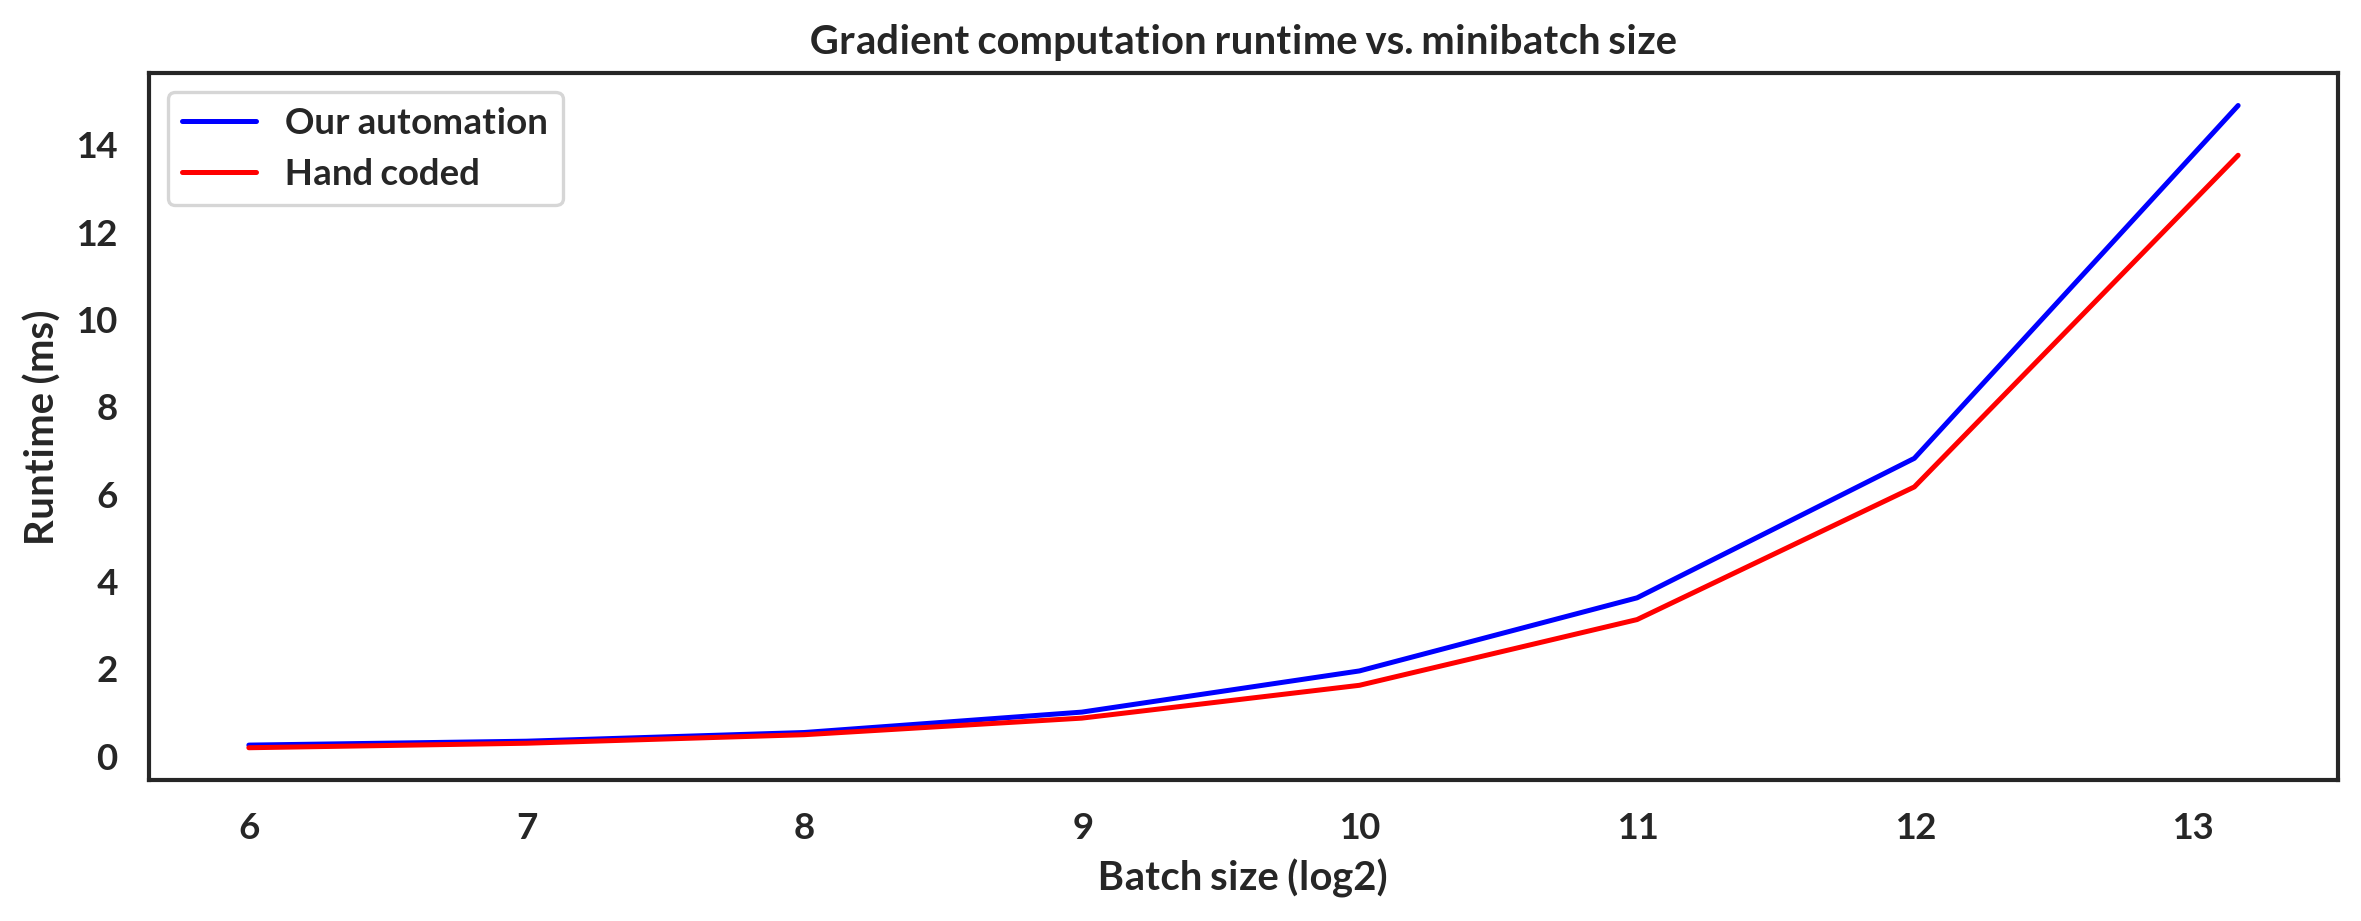

In [17]:
plt.rcParams["text.usetex"] = False
fig = plt.figure(figsize=(10, 4), dpi=240)
plt.plot(
    jnp.log2(jnp.array(batch_sizes)),
    1e3 * jnp.array(grasp_runtime_over_batches),
    label="Our automation",
    color="blue",
)
plt.plot(
    jnp.log2(jnp.array(batch_sizes)),
    1e3 * jnp.array(hand_runtime_over_batches),
    label="Hand coded",
    color="red",
)
plt.title("Gradient computation runtime vs. minibatch size")
plt.xlabel("Batch size (log2)")
plt.ylabel("Runtime (ms)")
plt.legend()
fig.savefig("img/overhead_batch_size.pdf", format="pdf")
plt.show()

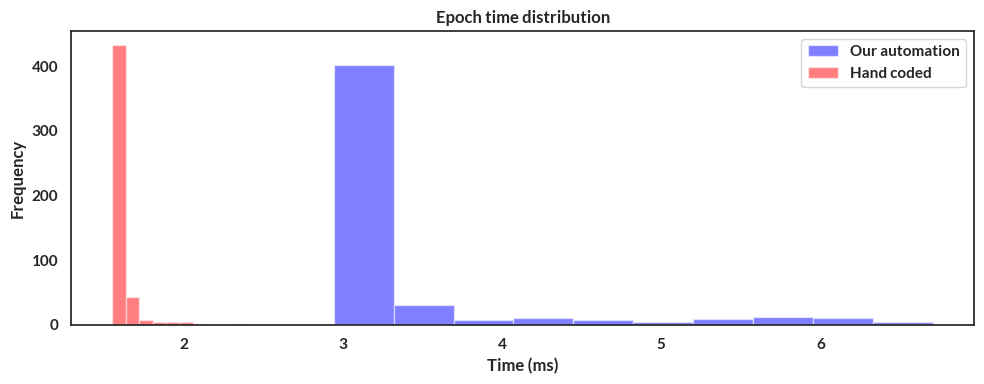

In [25]:
fig = plt.figure(figsize=(10, 4))
plt.hist(
    1e3 * jnp.array(grasp_epoch_times),
    bins=10,
    alpha=0.5,
    label="Our automation",
    color="blue",
)
plt.hist(
    1e3 * jnp.array(hand_epoch_times),
    bins=10,
    alpha=0.5,
    label="Hand coded",
    color="red",
)
plt.title("Epoch time distribution")
plt.xlabel("Time (ms)")
plt.ylabel("Frequency")
plt.legend()
fig.savefig("img/overhead_epoch_histogram.pdf", format="pdf")
plt.show()